In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, hamming_loss, f1_score

from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [50]:
y = pd.read_csv('../Data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Labels.csv')
X = pd.read_csv('../Data/X_train_clean.csv')
print(f"Shape of X_train: {X.shape}")
print(f"Shape of y_train: {y.shape}")
labels = ['h1n1_vaccine', 'seasonal_vaccine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Shape of X_train: (26707, 30)
Shape of y_train: (26707, 3)


In [51]:
y_train

,respondent_id,h1n1_vaccine,seasonal_vaccine
5303,5303,0,1
2703,2703,0,0
6586,6586,0,0
22563,22563,1,1
2338,2338,1,1
...,...,...,...
21575,21575,0,1
5390,5390,0,0
860,860,0,0
15795,15795,0,0


## This problem is a Multi-Label Problem:

$$
\mathcal{D} = \{(\mathbf{x_i}, \mathbf{y_i}) \; \text{for } i=1 ,2, ..., N\}
$$

Where:  $\mathbf{y_i} \: \in \; \mathbb{R}^2$

# Label Powerset Approach:

Treats each combination of labels as it's own distinct label in a multi-class setup:
The set of possible labels are therefore:

$$
\{ 00, \; 01, \; 10, \; 11 \}
$$

Therefore: $y \in \{ 1, \; 2, \; 3, \; 4 \}$ in that order.

In [82]:
print(y_train.head())

       respondent_id  h1n1_vaccine  seasonal_vaccine
5303            5303             0                 1
2703            2703             0                 0
6586            6586             0                 0
22563          22563             1                 1
2338            2338             1                 1


In [83]:
#Label Powerset model using XGBoost

# Vectorized encoding using binary logic
y_train_enc =  2 * y_train['h1n1_vaccine'].values + y_train['seasonal_vaccine'].values
y_test_enc =  2 * y_test['h1n1_vaccine'].values + y_test['seasonal_vaccine'].values

#y_train_enc = y_train_enc.to_numpy() if hasattr(y_train_enc, 'to_numpy') else y_train_enc


In [84]:
y_train_enc

array([1, 0, 0, ..., 0, 0, 0])

In [85]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train_enc)

y_pred_enc = xgb_model.predict(X_test)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:17:18] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [86]:
#decode the preds

codes = np.array(y_pred_enc)

# Recover the original bits
h1n1 = (codes // 2) % 2
seasonal = codes % 2

# Recombine into DataFrame
y_pred = pd.DataFrame({'h1n1_vaccine': h1n1, 'seasonal_vaccine': seasonal})

In [96]:
y_pred[labels].shape

(8013, 2)

In [97]:
y_test[labels].shape

(8013, 2)

In [100]:
y_test[labels].values

array([[0, 0],
       [0, 1],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [1, 1]])

In [101]:
# Exact match accuracy
XGB_acc = np.mean(y_test[labels].values == y_pred[labels].values)
print(f"Exact Match Accuracy LPS XGBoost: {XGB_acc}")

Exact Match Accuracy LPS XGBoost: 0.7560214651191813


In [90]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test[labels], y_pred[labels])
print(mcm)

[[[5851  468]
  [1086  608]]

 [[3478  864]
  [1492 2179]]]


In [75]:
print("Value Counts on Test Data")
print(y_test[labels].value_counts())

print("\nValue Counts on Pred Data")
print(y_pred[labels].value_counts())

Value Counts on Test Data
h1n1_vaccine  seasonal_vaccine
0             0                   4032
              1                   2287
1             1                   1384
              0                    310
Name: count, dtype: int64

Value Counts on Pred Data
h1n1_vaccine  seasonal_vaccine
1             1                   4959
0             0                   1978
1             0                   1065
0             1                     11
Name: count, dtype: int64


In [91]:
labels =['h1n1_vaccine', 'seasonal_vaccine']
print(classification_report(y_test[labels], y_pred, target_names=labels))

                  precision    recall  f1-score   support

    h1n1_vaccine       0.57      0.36      0.44      1694
seasonal_vaccine       0.72      0.59      0.65      3671

       micro avg       0.68      0.52      0.59      5365
       macro avg       0.64      0.48      0.54      5365
    weighted avg       0.67      0.52      0.58      5365
     samples avg       0.26      0.25      0.25      5365



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Using MultiOut sklearn

In [78]:


multi_model = MultiOutputClassifier(XGBClassifier())
multi_model.fit(X_train, y_train[labels])


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))

In [79]:
# Exact match accuracy
y_pred_multi = multi_model.predict(X_test)
multi_acc = np.mean(y_test[labels] == y_pred_multi)
print(f"Exact Match Accuracy LPS XGBoost: {multi_acc}")

Exact Match Accuracy LPS XGBoost: 0.7545862972669413


In [80]:
print(classification_report(y_test[labels], y_pred_multi, target_names=labels))

                  precision    recall  f1-score   support

    h1n1_vaccine       0.56      0.31      0.40      1694
seasonal_vaccine       0.69      0.65      0.67      3671

       micro avg       0.66      0.54      0.60      5365
       macro avg       0.63      0.48      0.53      5365
    weighted avg       0.65      0.54      0.58      5365
     samples avg       0.29      0.27      0.27      5365



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## MultiOut LGBM

In [81]:
lgm_model = MultiOutputClassifier(LGBMClassifier())
lgm_model.fit(X_train, y_train[labels])

# Exact match accuracy
y_pred_lgm = lgm_model.predict(X_test)
lgm_acc = np.mean(y_test[labels] == y_pred_lgm)
print(f"Exact Match Accuracy LPS XGBoost: {lgm_acc}")

print(classification_report(y_test[labels], y_pred_lgm, target_names=labels))

[LightGBM] [Info] Number of positive: 3980, number of negative: 14714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 18694, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212903 -> initscore=-1.307518
[LightGBM] [Info] Start training from score -1.307518
[LightGBM] [Info] Number of positive: 8764, number of negative: 9930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 18694, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468814 -> initscore=-0.124908
[LightGBM] [Info] Start training from score -0.124908
Exact Match Acc

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Multiout CatBoost

In [104]:
cat_model = MultiOutputClassifier(CatBoostClassifier())
cat_model.fit(X_train, y_train[labels])

# Exact match accuracy
y_pred_cat = cat_model.predict(X_test)
cat_acc = np.mean(y_test[labels] == y_pred_cat)
print(f"Exact Match Accuracy LPS catBoost: {cat_acc}")

print(classification_report(y_test[labels], y_pred_cat, target_names=labels))

Learning rate set to 0.035971
0:	learn: 0.6731025	total: 62.3ms	remaining: 1m 2s
1:	learn: 0.6552874	total: 66.1ms	remaining: 33s
2:	learn: 0.6386521	total: 70ms	remaining: 23.3s
3:	learn: 0.6233455	total: 74.1ms	remaining: 18.5s
4:	learn: 0.6092561	total: 78.4ms	remaining: 15.6s
5:	learn: 0.5962684	total: 82.1ms	remaining: 13.6s
6:	learn: 0.5847243	total: 85.8ms	remaining: 12.2s
7:	learn: 0.5735958	total: 89.8ms	remaining: 11.1s
8:	learn: 0.5630500	total: 93.1ms	remaining: 10.3s
9:	learn: 0.5541344	total: 97.5ms	remaining: 9.65s
10:	learn: 0.5457648	total: 101ms	remaining: 9.09s
11:	learn: 0.5383332	total: 105ms	remaining: 8.67s
12:	learn: 0.5318218	total: 109ms	remaining: 8.31s
13:	learn: 0.5247565	total: 114ms	remaining: 8.01s
14:	learn: 0.5179700	total: 118ms	remaining: 7.77s
15:	learn: 0.5125598	total: 122ms	remaining: 7.52s
16:	learn: 0.5071597	total: 126ms	remaining: 7.3s
17:	learn: 0.5022722	total: 131ms	remaining: 7.12s
18:	learn: 0.4969774	total: 134ms	remaining: 6.92s
19:	le

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [105]:
print(f"Exact Match Accuracy LPS catBoost: {cat_acc}")


Exact Match Accuracy LPS catBoost: 0.7713091226756521


## Final Model Hyperparameter tuning:

### Label Powerset CatBoost:

In [134]:
#Label Powerset model using CATboost

y_train_enc =  2 * y_train['h1n1_vaccine'].values + y_train['seasonal_vaccine'].values
y_test_enc =  2 * y_test['h1n1_vaccine'].values + y_test['seasonal_vaccine'].values

model = CatBoostClassifier(
    loss_function='MultiClass',
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=0
)

model.fit(X_train, y_train_enc)

y_pred = pd.DataFrame(cat_model.predict(X_test), columns=labels)
print(f"Label Powerset Exact match Accuracy: {np.mean(y_test[labels].values == y_pred[labels].values)}")

Label Powerset Exact match Accuracy: 0.7713091226756521


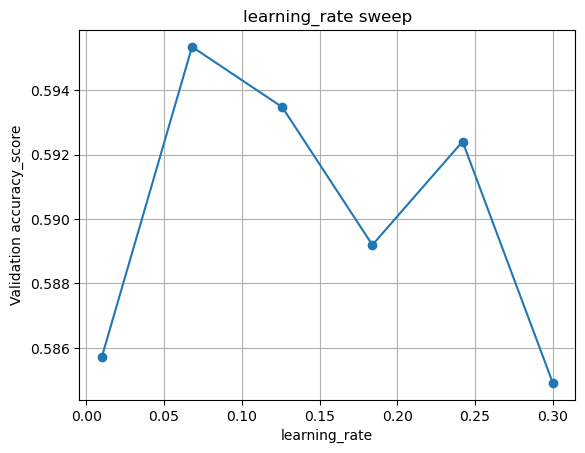

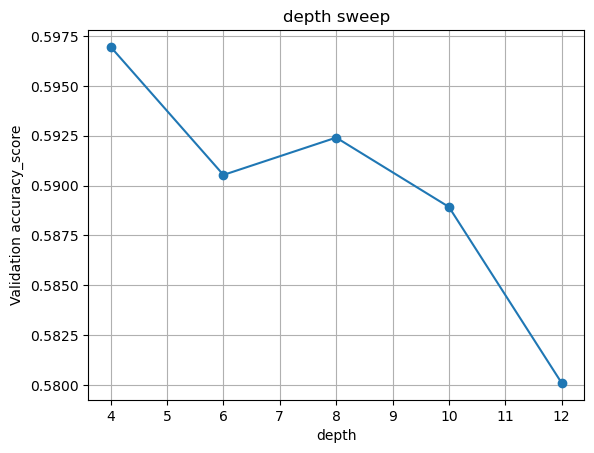

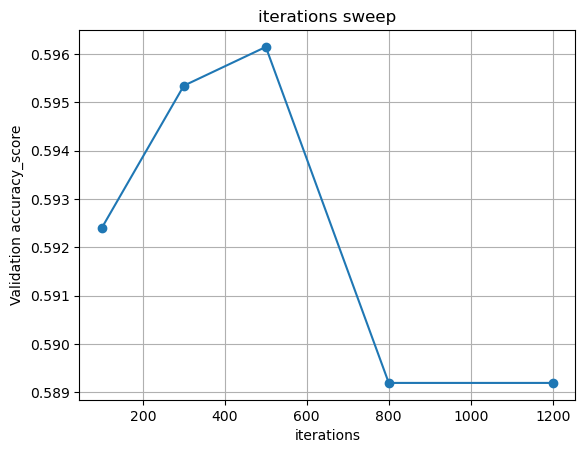

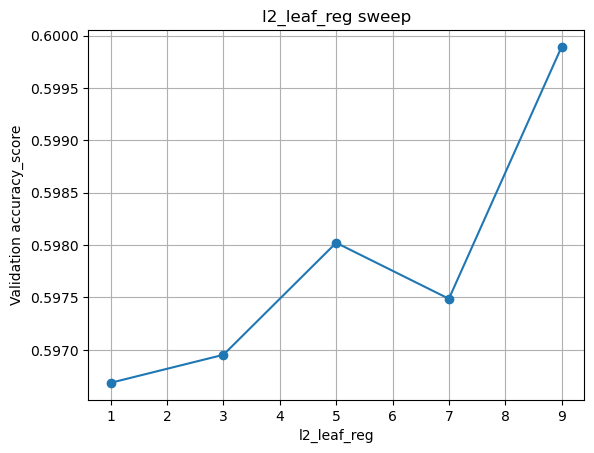

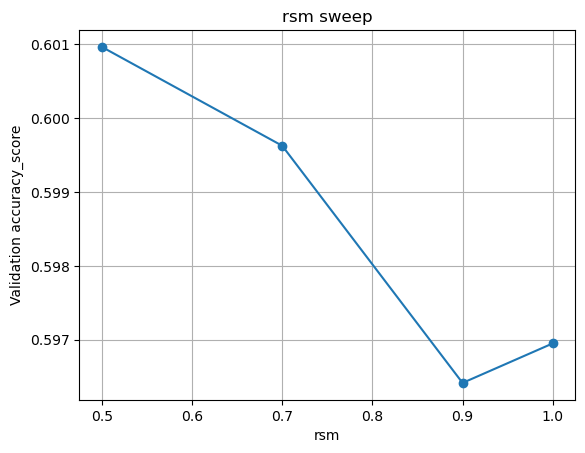

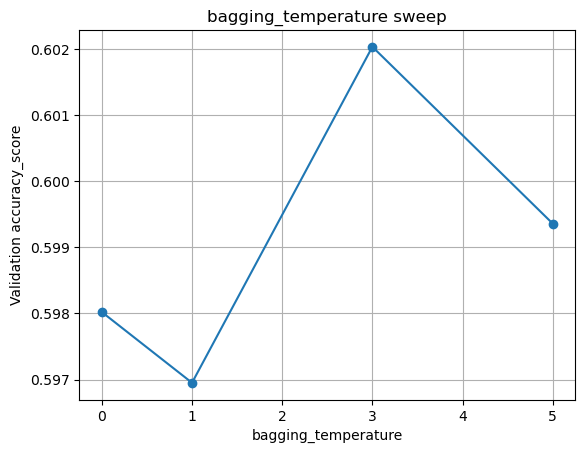

In [ ]:
# prep a hold out evaluation set:

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train_enc, test_size=0.2, random_state=42
)

def evaluate_param(name, values, fixed_params, metric_fn):
    scores = []
    for v in values:
        params = fixed_params.copy()
        params[name] = v
        model = CatBoostClassifier(**params, verbose=0)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(metric_fn(y_val, y_pred))
    return scores

# Define importance metric

metric = accuracy_score

base_params = {
    'loss_function': 'MultiClass',
    'iterations': 400,
    'learning_rate': 0.1,
    'depth': 4,
}

# For each hyperparam, define a range, evaluate, and plot
sweeps = {
    'learning_rate': np.linspace(0.01, 0.3, 6),
    'depth': [4, 6, 8, 10, 12],
    'iterations': [100, 300, 500, 800, 1200],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'rsm': [0.5, 0.7, 0.9, 1.0],           # feature subsampling
    'bagging_temperature': [0, 1, 3, 5],  # CatBoost-specific
}

for param, values in sweeps.items():
    scores = evaluate_param(param, values, base_params, metric)
    # Plotting
    plt.figure()
    plt.plot(values, scores, marker='o')
    plt.title(f"{param} sweep")
    plt.xlabel(param)
    plt.ylabel(f"Validation {metric.__name__}")
    plt.grid(True)
    plt.show()

In [ ]:
#final model:

y_train_enc =  2 * y_train['h1n1_vaccine'].values + y_train['seasonal_vaccine'].values
y_test_enc =  2 * y_test['h1n1_vaccine'].values + y_test['seasonal_vaccine'].values

model = CatBoostClassifier(
    loss_function='MultiClass',
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg = 9,
    rsm=0.5,
    bagging_temperature=3,
    verbose=0
)

model.fit(X_train, y_train_enc)

y_pred = pd.DataFrame(cat_model.predict(X_test), columns=labels)
print(f"Label Powerset Exact match Accuracy: {np.mean(y_test[labels].values == y_pred[labels].values)}")

Label Powerset Exact match Accuracy: 0.7713091226756521
